# Combine Loom

Combine Loom files per day (from `velocyto`) to a single AnnData.

In [155]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np

In [59]:
DAYS = ["D{:d}".format(d) for d in range(0,15,2)]
DAYS

['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14']

In [10]:
# load processed RNA
rna = sc.read_h5ad("../20200828_RNA_Seurat/sessions/20200913_n27632/seurat.h5ad")

In [123]:
# load looms (from velocyto)
loom_adatas = []

for d in DAYS:
    loom_adatas.append(scv.read('/srv/scratch/surag/scRNA-reprog/velocyto/{:s}.loom'.format(d), cache=True))
    # some gene names are dup-ed
    loom_adatas[-1].var_names_make_unique()
    
loom_adata = loom_adatas[0].concatenate(*loom_adatas[1:])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make 

In [124]:
loom_adata

AnnData object with n_obs × n_vars = 81706 × 36601
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [130]:
loom_adata.obs.head()

,Clusters,_X,_Y,batch
D0:AAACCCAGTTATTCTCx-0,8,-2.639777,6.698133,0
D0:AAACGCTTCGTGCGACx-0,4,-25.482784,-16.161640,0
D0:AAACGCTGTAGAGGAAx-0,2,-1.433096,-15.862327,0
D0:AAAGGTAGTCTCAGGCx-0,6,4.602793,-9.048930,0
D0:AAACGCTAGCAACTCTx-0,4,-8.913074,-11.779467,0


In [129]:
rna.obs.head()

,nCount_RNA,nFeature_RNA,sample,percent.mt,selected,percent.or,RNA_snn_res.1,seurat_clusters,RNA_snn_res.0.5
AAACCCAAGAGTGACC-1,12431.0,3300,D0,4.231357,0.0,0.0,0,0,0
AAACCCAAGTGCCAGA-1,11132.0,3304,D0,5.821056,1.0,0.0,0,0,0
AAACCCACACCATTCC-1,13101.0,3788,D0,4.121823,0.0,0.0,7,0,0
AAACCCACACGCGTCA-1,7944.0,2612,D0,4.770896,1.0,0.0,0,0,0
AAACCCAGTCCATAGT-1,10934.0,3080,D0,6.036217,0.0,0.0,7,0,0


Need to match barcodes. Seurat object has Barcode-{1,2,3,4,5,6,7,8} where 1-8 correspond to D0-D14.

In [140]:
loom_adata.obs.tail()

,Clusters,_X,_Y,batch
D14:TTTGTTGCACCGTGACx-7,9,47.708885,19.407852,7
D14:TTTGGTTAGGATGTTAx-7,7,-29.613766,2.475100,7
D14:TTTGTTGCAGGACTTTx-7,2,-42.803905,17.457087,7
D14:TTTGGTTGTCGATTACx-7,2,-44.272461,19.298035,7
D14:TTTGATCGTATCGGTTx-7,4,-17.164248,3.090986,7


In [138]:
def convert_barcode(loom_bcode):
    day, bcode = loom_bcode.split(":")
    bcode = bcode.split('x')[0]
    return "{:s}-{:d}".format(bcode,
                             DAYS.index(day)+1)

In [143]:
converted_barcodes = [convert_barcode(x) for x in list(loom_adata.obs.index)]

In [146]:
converted_barcodes[:10]

['AAACCCAGTTATTCTC-1',
 'AAACGCTTCGTGCGAC-1',
 'AAACGCTGTAGAGGAA-1',
 'AAAGGTAGTCTCAGGC-1',
 'AAACGCTAGCAACTCT-1',
 'AAAGTCCGTACAGGTG-1',
 'AAACGCTTCCATTGTT-1',
 'AAACCCACAACTCGAT-1',
 'AAACCCACACGCGTCA-1',
 'AAAGTGAGTAGTTAGA-1']

In [147]:
len(rna.obs.index)

59369

In [148]:
len(set(rna.obs.index).intersection(set(converted_barcodes)))

59369

The above two should match.

In [150]:
loom_adata.obs.index = pd.Index(converted_barcodes)

In [151]:
loom_adata.obs.head()

,Clusters,_X,_Y,batch
AAACCCAGTTATTCTC-1,8,-2.639777,6.698133,0
AAACGCTTCGTGCGAC-1,4,-25.482784,-16.161640,0
AAACGCTGTAGAGGAA-1,2,-1.433096,-15.862327,0
AAAGGTAGTCTCAGGC-1,6,4.602793,-9.048930,0
AAACGCTAGCAACTCT-1,4,-8.913074,-11.779467,0


In [152]:
merged = scv.utils.merge(rna, loom_adata)

In [153]:
merged

AnnData object with n_obs × n_vars = 59369 × 27624
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'selected', 'percent.or', 'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.5', 'Clusters', '_X', '_Y', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

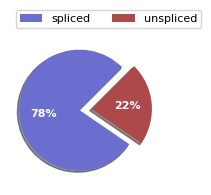

In [156]:
scv.pl.proportions(merged)

In [165]:
rand_idx = np.random.randint(0, merged.shape[0], 10)
rand_idx

array([27518, 52174, 19357, 22665,  7149, 56926, 20251, 35546, 57699,
       34489])

In [171]:
np.sum(merged.layers['spliced'] + merged.layers['unspliced'] + merged.layers['ambiguous'], axis=1)[rand_idx]

matrix([[27235],
        [18964],
        [14572],
        [16170],
        [ 9981],
        [11413],
        [ 9201],
        [10152],
        [20358],
        [10497]], dtype=uint64)

In [172]:
np.sum(merged.layers['matrix'], axis=1)[rand_idx]

matrix([[27235.],
        [18964.],
        [14572.],
        [16170.],
        [ 9981.],
        [11413.],
        [ 9201.],
        [10152.],
        [20358.],
        [10497.]], dtype=float32)

The above two should match and be non-zero.

In [177]:
tot = np.sum(merged.layers['matrix'], axis=1)

In [197]:
from scipy.stats import pearsonr, spearmanr

In [196]:
pearsonr(merged.obs["nCount_RNA"], np.squeeze(np.asarray(tot)))

(0.9051334134707267, 0.0)

In [200]:
spearmanr(merged.obs["nCount_RNA"], np.squeeze(np.asarray(tot)))

SpearmanrResult(correlation=0.9363937641746577, pvalue=0.0)

These correlate fairly strongly.

## Save Merged Output

In [206]:
merged.write_h5ad("./sessions/20200913_n27632/seurat_with_velocyto.h5ad")

---